<a href="https://colab.research.google.com/github/VanKhaiii/CS221_NLP/blob/main/ViT5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q datasets transformers==4.28.0 evaluate seqeval unidecode==1.3.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
#Import libraries to project
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
import torch
from datasets import Dataset
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import json
import pandas as pd
from unidecode import unidecode

**Clone Data**

In [ ]:
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git

Cloning into 'PhoNER_COVID19'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 58 (delta 23), reused 41 (delta 18), pack-reused 0
Receiving objects: 100% (58/58), 3.61 MiB | 12.84 MiB/s, done.
Resolving deltas: 100% (23/23), done.


**Data Preparation**

In [ ]:
#Traing Data
trainWord = [json.loads(line) for line in open('/content/PhoNER_COVID19/data/word/train_word.json', 'r', encoding='utf-8')]
valWord = [json.loads(line) for line in open('/content/PhoNER_COVID19/data/word/dev_word.json', 'r', encoding='utf-8')]
testWord = [json.loads(line) for line in open('/content/PhoNER_COVID19/data/word/test_word.json', 'r', encoding='utf-8')]

df_trainWordData = pd.DataFrame(trainWord)
df_valWordData = pd.DataFrame(valWord)
df_testWordData = pd.DataFrame(testWord)

df_trainWordData.tail(5)

,words,tags
5022,"[Liên_quan, đến, Bệnh_viện, Bạch_Mai, ,, ông, ...","[O, O, B-LOCATION, I-LOCATION, O, O, O, O, O, ..."
5023,"[Mẫu, lần, hai, ngày, 22/7, kết_quả, sàng_lọc,...","[O, O, O, O, B-DATE, O, O, O, O]"
5024,"[Đây, là, 5, trường_hợp, dương_tính, được, Bộ,...","[O, O, O, O, O, O, B-ORGANIZATION, I-ORGANIZAT..."
5025,"[Lúc, 17h, ngày, 7, -, 3, ,, Viện, Vệ_sinh, Dị...","[O, O, O, B-DATE, I-DATE, I-DATE, O, B-ORGANIZ..."
5026,"[Ngày, 12/8, ,, anh, được, cách_ly, tập_trung,...","[O, B-DATE, O, O, O, O, O, O, O, B-DATE, O, O,..."


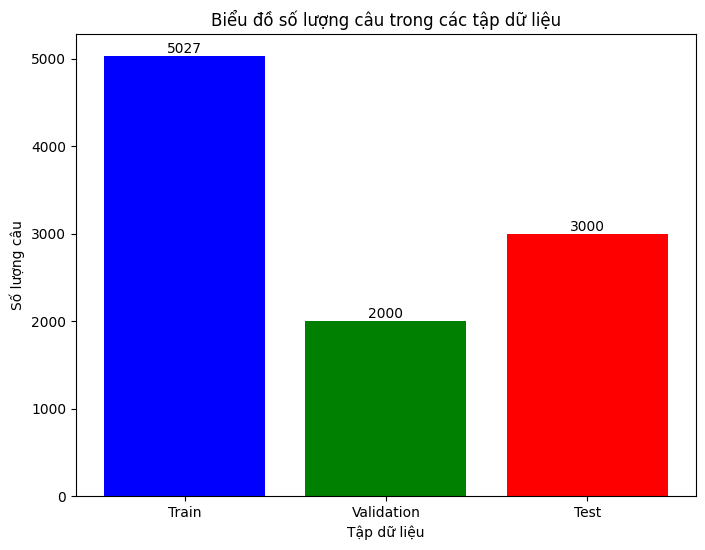

In [ ]:
import matplotlib.pyplot as plt

# Tạo danh sách chứa số lượng câu của từng dataframe
dataframes = [df_trainWordData, df_valWordData, df_testWordData]
labels = ['Train', 'Validation', 'Test']
sentence_counts = [df['words'].count() for df in dataframes]

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, sentence_counts, color=['blue', 'green', 'red'])
plt.xlabel('Tập dữ liệu')
plt.ylabel('Số lượng câu')
plt.title('Biểu đồ số lượng câu trong các tập dữ liệu')

# Thêm số lượng câu trên đầu từng cột
for bar, count in zip(bars, sentence_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.show()


In [ ]:
inputs = df_trainWordData['words']
trainWordData = []

for sentence in inputs:
  trainWordData.append(' '.join(sentence))

len(trainWordData), trainWordData[0]

(5027,
 'Đồng_thời , bệnh_viện tiếp_tục thực_hiện các biện_pháp phòng_chống dịch_bệnh COVID - 19 theo hướng_dẫn của Bộ Y_tế .')

In [ ]:
input_ = df_valWordData['words']
valWordData = []

for sentence in input_:
  valWordData.append(' '.join(sentence))

len(valWordData), valWordData[0]

(2000,
 'Bác_sĩ Nguyễn_Trung_Nguyên , Giám_đốc Trung_tâm Chống độc , Bệnh_viện Bạch_Mai , cho biết bệnh_nhân được chuyển đến bệnh_viện ngày 7/3 , chẩn_đoán ngộ_độc thuốc điều_trị sốt_rét chloroquine .')

In [ ]:
def formating_target(text, label):
  s = ""
  texts = []
  for i in range(len(text)-1):
    if label[i] != 'O':
      s += text[i] + " "
      if label[i+1] == 'O' or label[i+1][0:1] == 'B':
        s = label[i][2:] + ": " + s
        texts.append(s.strip())
        s = ""
  texts = "; ".join(texts)
  return texts

In [ ]:
example = formating_target(df_trainWordData['words'][5], df_trainWordData['tags'][5])
example

'PATIENT_ID: 188; NAME: L.T.H.; DATE: 14 - 4'

In [ ]:
label_trainWordData = []
for i in range(5027):
  text = df_trainWordData['words'][i]
  label = df_trainWordData['tags'][i]

  target = formating_target(text, label)
  label_trainWordData.append(target)

label_valWordData = []
for i in range(2000):
  text = df_valWordData['words'][i]
  label = df_valWordData['tags'][i]

  target = formating_target(text, label)
  label_valWordData.append(target)

In [ ]:
valWordData[718], label_valWordData[718]

('Lo_ngại nhất là tối 14/3 ông ấy dự buổi tiệc Patrick day ở Buddha_Bar & Grill với sự tham_dự của hàng trăm người , chủ_yếu là người nước_ngoài sinh_sống , làm_việc tại quận 2 .',
 'DATE: 14/3; LOCATION: Buddha_Bar & Grill; LOCATION: quận 2')

**Train**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")

(…)ietAI/vit5-base/resolve/main/config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [ ]:
def preprocess(examples):
  model_inputs = tokenizer(
      examples["inputs"], max_length=1024, truncation=True, padding=True
  )
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        examples["labels"], max_length=1024, truncation=True, padding=True
    )
  model_inputs["labels"] = labels['input_ids']
  model_inputs['input_ids'] = model_inputs['input_ids']
  return model_inputs

In [ ]:
#Tokenise dataset
dict_obj = {'inputs':trainWordData, 'labels':label_trainWordData}
dataset = Dataset.from_dict(dict_obj)
train_tokenized_datasets = dataset.map(preprocess, batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/5027 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [ ]:
#Tokenise dataset
dict_obj = {'inputs':valWordData, 'labels':label_valWordData}
dataset = Dataset.from_dict(dict_obj)
val_tokenized_datasets = dataset.map(preprocess, batched=True, num_proc=8)

In [ ]:

#Arguments for training model
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")
training_args = Seq2SeqTrainingArguments('/content/drive/MyDrive/CS221_NLP/ViT5_Ner/checkpoint_vit5',
                                      do_train=True,
                                      do_eval=False,
                                      num_train_epochs=10,
                                      learning_rate=2e-5,
                                      warmup_ratio=0.00,
                                      weight_decay=0.01,
                                      per_device_train_batch_size=4,
                                      per_device_eval_batch_size=4,
                                      logging_dir='./log',
                                      group_by_length=True,
                                      save_strategy="epoch",
                                      save_total_limit=3,
                                      #eval_steps=1,
                                      #evaluation_strategy="steps",
                                      # evaluation_strategy="no",
                                      # fp16=True,
                                      )

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_datasets,
    #eval_dataset=val_tokenized_datasets,
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.585400
1000,0.030400
1500,0.016100
2000,0.012100
2500,0.010900
3000,0.008500
3500,0.006500
4000,0.005100
4500,0.004800
5000,0.005100


Step,Training Loss
500,0.585400
1000,0.030400
1500,0.016100
2000,0.012100
2500,0.010900
3000,0.008500
3500,0.006500
4000,0.005100
4500,0.004800
5000,0.005100


TrainOutput(global_step=12570, training_loss=0.02828780431167038, metrics={'train_runtime': 6760.6423, 'train_samples_per_second': 7.436, 'train_steps_per_second': 1.859, 'total_flos': 1.20633844497408e+16, 'train_loss': 0.02828780431167038, 'epoch': 10.0})

#Inference


In [ ]:
text = 'Bệnh nhân 774, không có triệu chứng, địa chỉ quận 2 TP HCM'

In [ ]:
#Load model saved as a checkpoint
from transformers import AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained('VietAI/vit5-base')
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/CS221_NLP/ViT5_Ner/checkpoint_vit5/checkpoint-12570")

(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

(…)AI/vit5-base/resolve/main/tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

(…)ase/resolve/main/special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

In [ ]:
#Total number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

225950976

In [ ]:
model.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
!pip install python-rdrsegmenter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.1 MB/s eta 0:00:00


In [ ]:
from python_rdrsegmenter import load_segmenter
segmenter = load_segmenter()
text = "bệnh nhân tên N.N.T, 20 tuổi, thành phố Kon Tum, đau khớp thái dương, sinh viên, thích đá banh"
a = text
segmenter.tokenize(text)

'bệnh_nhân tên N.N.T, 20 tuổi, thành_phố Kon Tum, đau khớp thái dương, sinh viên, thích đá banh'

In [ ]:
encoding = tokenizer(text, return_tensors="pt", max_length=1024)
input_ids, attention_masks = encoding["input_ids"], encoding["attention_mask"]
outputs = model.generate(
    input_ids=input_ids, attention_mask=attention_masks,
    max_length=1024,
)
labels = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

print()
print()
print("Input: ", a)
print ("Output: ", labels)



Input:  bệnh nhân tên N.N.T, 20 tuổi, thành phố Kon Tum, đau khớp thái dương, sinh viên, thích đá banh
Output:  *, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh, thích đá banh


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
def word_labels(sentence, labels):
  predictions = ["O" for i in range(len(sentence.split()))]
  #print(len(predictions))
  if labels != '':
    list_labels = labels.split(";")
    sent = sentence.split()

    start = 0
    for i in range(len(list_labels)):
      sub_list = list_labels[i].split(":")
      try:
        class_entity = sub_list[0].strip() # location, organization, age,...
        named_entity = sub_list[1].strip().lower() # Ha Noi, London, 433,...
        named_entity_element = named_entity.split() # Ha, Noi, London, 433, Soc Trang,..

        flist = []
        for i in range(len(named_entity_element)):
          if named_entity_element[i][-1] == ',':
            entity1 = named_entity_element[i][0:len(named_entity_element[i])-1]
            entity2 = ","
            flist.append(entity1)
            flist.append(entity2)
          else:
            flist.append(named_entity_element[i])

        named_entity_element = flist
        for i in range(len(named_entity_element)):
          try:
            findex = sent.index(named_entity_element[i], start)
            start = findex + 1
            f_class = ""
            if i == 0:
              f_class = "B-" + class_entity
            else:
              f_class = "I-" + class_entity
            predictions[findex] = f_class
          except:
            pass
      except:
        pass

  return predictions

**Load dataset for evaluation**

In [ ]:
#test set
evalWordData = df_testWordData.rename(columns={'tags':'target_text', 'words':'source_text'})

In [ ]:
#Create a list of texts
eval_input_data = evalWordData['source_text']
eval_input_sequences = []

for sentence in eval_input_data:
  eval_input_sequences.append(" ".join(sentence))

#Create a list of targets
eval_output_data = evalWordData['target_text']
eval_output_sequences = []

for sentence in eval_output_data:
  eval_output_sequences.append(" ".join(sentence))

In [ ]:
!pip install unidecode

In [ ]:
from unidecode import unidecode

a = "\"", "Bệnh_nhân", "355", "\"", ",", "43", "tuổi", ",", "ở", "huyện", "Như_Xuân", ",", "Thanh_Hoá", ".", "￼￼"
b = " ".join(a)
c = b.split()
print(c)
d = unidecode(b).lower() + "￼￼"
print(d)

['"', 'Bệnh_nhân', '355', '"', ',', '43', 'tuổi', ',', 'ở', 'huyện', 'Như_Xuân', ',', 'Thanh_Hoá', '.', '￼￼']
" benh_nhan 355 " , 43 tuoi , o huyen nhu_xuan , thanh_hoa . ￼￼


In [ ]:
model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
predictions = []
references = []

for i in range(3000):
  print(i)
  sentence = eval_input_sequences[i]
  tokenized_input = tokenizer(sentence, return_tensors='pt', max_length=1024, truncation=True, padding=True)
  input_ids = tokenized_input['input_ids'].to('cuda')
  attention_mask = tokenized_input['attention_mask'].to('cuda')

  outputs = model.generate(
      input_ids=input_ids, attention_mask=attention_mask, max_length=1024
      )
  labels = tokenizer.decode(outputs[0], clean_up_tokenization_spaces=True, skip_special_tokens=True, truncation=True)

  if i == 482 or i == 1800:
    sentence = unidecode(sentence.lower()) + "￼￼"
  else:
    sentence = unidecode(sentence.lower())
  labels = unidecode(labels)
  flabels = word_labels(sentence, labels)
  predictions.append(flabels)
  references.append(eval_output_sequences[i].split())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#TEST EROR

In [ ]:
predictions = []
references = []

In [ ]:
sentence = eval_input_sequences[1800]
print(sentence)
tokenized_input = tokenizer(sentence, return_tensors='pt', max_length=1024)
input_ids = tokenized_input['input_ids'].to('cuda')
attention_mask = tokenized_input['attention_mask'].to('cuda')
outputs = model.to('cuda').generate(
    input_ids=input_ids, attention_mask=attention_mask, max_length=1024
    )
labels = tokenizer.decode(outputs[0], clean_up_tokenization_spaces=True, skip_special_tokens=True)
print(labels)

sentence = unidecode(sentence.lower())
labels = unidecode(labels)
flabels = word_labels(sentence, labels)
predictions.append(flabels)

7 : nữ 53 tuổi , ở Phường Hoà_hiệp Bắc , quận Liên_Chiểu , TP Đà_Nẵng . ​
LOCATION: Phường Hoà_hiệp Bắc; LOCATION: quận Liên_Chiểu; LOCATION: TP Đà_Nẵng


In [ ]:
print("True Label: ", eval_output_sequences[718].split())
print("Model generate: ", labels)

True Label:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PATIENT_ID', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Model generate:  NAME: N.; D; JOB: nhan_vien y_te; PATIENT_ID: 889; ORGANIZATION: Bo Y_te; DATE: 13 - 8


In [ ]:
print(predictions[480])
print(eval_output_sequences[480].split())

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O']


In [ ]:
print(len(predictions[482]))
print(len(eval_output_sequences[482].split()))

14
15


#Evaluation

In [ ]:
from seqeval.metrics import f1_score, classification_report
print(classification_report(references, predictions, digits=4))

                     precision    recall  f1-score   support

                AGE     0.9315    0.9347    0.9331       582
               DATE     0.9842    0.9819    0.9831      1654
             GENDER     0.9344    0.9242    0.9293       462
                JOB     0.7193    0.7110    0.7151       173
           LOCATION     0.9306    0.9239    0.9272      4441
               NAME     0.9397    0.8333    0.8833       318
       ORGANIZATION     0.8546    0.8768    0.8656       771
         PATIENT_ID     0.9724    0.9661    0.9692      2005
SYMPTOM_AND_DISEASE     0.8538    0.8583    0.8560      1136
     TRANSPORTATION     0.9538    0.9637    0.9588       193

          micro avg     0.9304    0.9254    0.9279     11735
          macro avg     0.9074    0.8974    0.9021     11735
       weighted avg     0.9306    0.9254    0.9279     11735

